# End-to-end Neural Networks for NLP

## Word Embeddings

If everything is going well, you have used PyTorch to make a classifier based on logistic regression. Also, you are probably mildly annoyed by the fact that the accuracy was essentially the same as what we had with our previous version using scikit-learn, with the added difficulty that we had to write a loop all by ourselves.

Now it is time to do some math and review our models.

### Some underlying math of the bag-of-words model

In our current model, we represent each word by a line-vector $x_n$ with $v$ dimensions, where $v$ is the length of our vocabulary. Therefore, a document with $n$ words can be represented by a matrix of words within a document $X^{(d)}$ as:

$$
X^{(d)} = 
\begin{bmatrix} 
                        x^{(d)} _{1,1} & x^{(d)}_{1,2} & \cdots & x^{(d)}_{1,d} \\
                        x^{(d)}_{2,1} & x^{(d)}_{2,2} & \cdots & x^{(d)}_{2,d} \\
                        \vdots & \vdots & \ddots & \vdots \\
                        x^{(d)}_{N,1} & x^{(d)}_{N,2} & \cdots & x^{(d)}_{N,d} \\
                        \end{bmatrix}
$$

Then, we essentially sum all elements of the matrix to get a count. This maps the sequence of words to a single vector $x$ that represents our document:

$$
x^\prime_j = \sum _{i=1}^n x^{(d)}_{i,j}
$$

This is the same as pre-multiplying $W$ by a line-matrix of ones:

$$
x^\prime_j = [1, 1, \cdots, 1] \begin{bmatrix}
x^{(d)}_1 \\
x^{(d)}_2 \\ 
\cdots \\
x^{(d)}_n
\end{bmatrix}
$$

Last, if we want to binarize this vector, we simply apply an element-wise non-linearity such as:

$$
x = f(x^\prime),
$$
where $f(x)=1$ if $x>0$ and $f(x)=0$ otherwise.

Essentially, what we must do is:

1. Get a representation for each word
1. Combine the word representations for a document into a single representation
1. Use some non-linearity to modulate the representation as needed

Our solutions, so far, are:

1. Use a one-hot encoding
1. Use a simple summation
1. Use a step-function with a suitable threshold

The reason we have these solutions is that they somehow *make sense*. But now let's raise a question: are they the *best* solutions?

### Problems with the sparse representation

The one-hot encoding for words is easy to understand, but, at the same time, has some problems. 

The first, and more obvious, is that the dimensionality of the representation grows when the vocabulary grows. This is a problem because the amount of required data to train a system is typically a function of its dimension - hence, the more words we have, the more data we need. The vocabulary typically grows when we add more texts to the dataset, so this actually means: the more data we have, the more data we need.

The second is that our data matrix starts getting too big. Maybe it stops fitting memory - and this is because we have so many columns! Maybe we could do something about this?

The third, and less obvious, is that the distance between words is the same, regardless of their meaning. Hence, when we learn about dungeons, our system learns nothing about dragons. In fact, classifiers based on one-hot bag-of-words have no internal representation indicating that dungeons and dragons go more or less together.

### Dense representations

So, let's do something else. Let's say that each word is now going to be represented as a vector in some $\mathbb{R}^N$ space. We are free to choose $N$. This representation is called *embedding*.

Embeddings are *dense* representations, meaning that all dimensions are important. The name *dense* opposes to the *sparse* idea of the one-hot encoding in which only one dimension is important per word, and only a few dimensions are important per document.

What we *want* here is to have all words being represented in locations of $\mathbb{R}^N$ that reflect their meaning. But, what is *meaning*?

This is a complicated question, which we will approach during this course.

For now, let's go on and code a little.

### Coding with embeddings

To map words to their embeddings, we use a data structure that is very similar to a dictionary. The structure is wrapped in an *embedding layer* in Pytorch. 

It receives a sequence of integers as input. Each of these integer corresponds to a token in the vocabulary. For now, we will assume that each token corresponds to a word. Then, it yields a sequence of vectors for each document:

In [2]:
import torch
import torch.nn as nn

# Parameters of the embedding layer
vocab_size = 100  # Number of unique tokens
embedding_dim = 2  # You can choose the dimension of the embeddings
embedding_layer = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)

# Documents are now represented as sequences of tokens.
# Each token is an integer representing the index of the token in the vocabulary.
# tensor below: documents x tokens/words matrix.
tokens = torch.tensor([ [0, 1, 2, 3],
                        [4, 5, 4, 3],
                        [5, 4, 3, 2] ])

# Get the embeddings for the tokens
embeddings = embedding_layer(tokens)

print(embeddings)
print(embeddings.shape)

tensor([[[ 0.1382, -0.1535],
         [ 0.1064, -0.8048],
         [-0.7146,  1.2381],
         [ 0.0328,  0.1860]],

        [[-1.4498, -1.4511],
         [ 0.4536, -0.2331],
         [-1.4498, -1.4511],
         [ 0.0328,  0.1860]],

        [[ 0.4536, -0.2331],
         [-1.4498, -1.4511],
         [ 0.0328,  0.1860],
         [-0.7146,  1.2381]]], grad_fn=<EmbeddingBackward0>)
torch.Size([3, 4, 2])


Note that, in the code above, we yielded a batch of three texts to the embedding layer. The batch has a length of four. Then, the embedding layer returns a tensor with tridimensional shape. The shape $3 \times 4 \times 2$ means:

* We have 3 documents
* Each document has 4 tokens
* Each word is encoded in 2 dimensions

## Strategies for tokenization

Just some minutes ago, we discussed that a token corresponds to a word. In fact, a token is a piece of the text that conveys some information - and this could be a word. Also, we have used n-grams as tokens when we wanted to consider the sequence of words.

Now, let's remember. If we had around, maybe, $10^4$ words in our vocabulary, then we would have potentially $10^8$ bi-grams, and $10^{12}$ potential tri-grams. This is because we are aggreting more and more possible symbols.

However, we could go on the opposite direction here.

If we had the words "working", "works", "walking", "walks", "calling", and "calls", we could easily tokenize them into 6 tokens, each corresponding to full words.

However, we could separate the suffixes and the stems. In this case, we could have tokens for: "work", "walk", "call", "s", and "ing". See: now we have 5 tokens instead of 6.

This is generally called a "subword" tokenization strategy. One of the most used algorithms for such is called Sentence Piece Tokenizer. It works by building a vocabulary like this:

1. Assume each character is a separate token
1. Create a new token that merges the most common token sequence into a separate token
1. Repeat the merging until we reach a reasonable vocabulary size

A nice advantage of using this method is that it is less likely to find unknown tokens - afterall, we start from a limited vocabulary.

Also, we are not going to build a tokenizer from scratch: instead, we are going to use a ready-made one. If you want to read all about it, refer to:

[Kudo, T., and Richardson, J. SentencePiece: A simple and language independent subword tokenizer and detokenizer for Neural Text Processing (2018)](https://arxiv.org/pdf/1808.06226)

### Example code for training a Sentence Piece tokenizer:

In [3]:
import sentencepiece as spm
from io import StringIO

# Your input data as a string
input_data = """Was ever feather so lightly blown to and fro as this multitude? The
name of Henry the Fifth hales them to an hundred mischiefs and makes
them leave me desolate. I see them lay their heads together to surprise
me. My sword make way for me, for here is no staying.—In despite of the
devils and hell, have through the very middest of you! And heavens and
honour be witness that no want of resolution in me, but only my
followers’ base and ignominious treasons, makes me betake me to my
heels.
"""

# Use StringIO to create a file-like object
input_fp = StringIO(input_data)

# Train the SentencePiece model using the file pointer
spm.SentencePieceTrainer.train(
    sentence_iterator=input_fp, 
    model_prefix='my_tokenizer', 
    vocab_size=100
)

### Example code to test the trained tokenizer:

In [4]:
# Load the trained SentencePiece model
sp = spm.SentencePieceProcessor()
sp.load('my_tokenizer.model')

# Test the tokenizer
test_sentence = "This is a test sentence."
encoded_pieces = sp.encode_as_pieces(test_sentence)
encoded_ids = sp.encode_as_ids(test_sentence)
recovered_sentence = sp.decode_ids(encoded_ids)

print("Encoded pieces:", encoded_pieces)
print("Encoded ids:", encoded_ids)
print("Recovered sentence:", recovered_sentence)

Encoded pieces: ['▁', 'T', 'hi', 's', '▁', 'is', '▁', 'a', '▁', 't', 'es', 't', '▁s', 'e', 'n', 't', 'e', 'n', 'c', 'e', '.']
Encoded ids: [3, 82, 90, 7, 3, 28, 3, 59, 3, 9, 54, 9, 30, 4, 14, 9, 4, 14, 83, 4, 20]
Recovered sentence: This is a test sentence.


## Zero-padding and truncation: keeping sentences the same length

If you have been paying attention, you probably realized that, in any language, sentences have different lengths. However, PyTorch works with tensors, hence the inputs for an embedding layer should have the same length.

If we find long sentences, we could just truncate them so a desired length.

However, if we find a short sentence, the procedure is different. Usually, we insert a special token called "padding" so that the sentence artificially becomes our desired length:

In [6]:
# Use StringIO to create a file-like object
input_fp = StringIO(input_data)

# Train the SentencePiece model using the file pointer
spm.SentencePieceTrainer.train(
    sentence_iterator=input_fp, 
    model_prefix='my_tokenizer', 
    vocab_size=100,
    user_defined_symbols=['<PAD>']
)


In [7]:
sp = spm.SentencePieceProcessor()
sp.load('my_tokenizer.model')
print(sp.piece_to_id('<PAD>'))

3


In [14]:
# Create an embedding layer with padding index set to 3
def pad_to_len(sequences, pad_idx, max_len):
    padded = []
    for s in sequences:
        if len(s) >= max_len:
            padded.append(s[:max_len])
        else:
            padded.append(s + [pad_idx] * (max_len - len(s)))
    return padded

vocab_size = len(sp)
embedding_dim = 2
padding_idx = sp.piece_to_id('<PAD>')
embedding_layer_with_padding = nn.Embedding(
    num_embeddings=vocab_size,
    embedding_dim=embedding_dim,
    padding_idx=padding_idx,   
)

# Get the embeddings for the tokens using the new embedding layer
input_data = ["This is my test sentence", "This is another test sentence", "this is a really long sequence and I will probably have to crop it!"]
tokens = sp.tokenize(input_data)
tokens = pad_to_len(tokens, padding_idx, 25)
print(tokens)
embeddings_with_padding = embedding_layer_with_padding(torch.tensor(tokens))
#print(embeddings_with_padding)
print(embeddings_with_padding.shape)

[[4, 83, 91, 8, 4, 29, 26, 6, 4, 10, 55, 10, 31, 5, 15, 10, 5, 15, 84, 5, 3, 3, 3, 3, 3], [4, 83, 91, 8, 4, 29, 78, 56, 10, 58, 4, 10, 55, 10, 31, 5, 15, 10, 5, 15, 84, 5, 3, 3, 3], [34, 29, 4, 29, 4, 60, 4, 35, 60, 96, 6, 40, 28, 42, 31, 5, 0, 27, 5, 15, 84, 5, 16, 4, 45]]
torch.Size([3, 25, 2])


## How far have we gone?

So far, we have tokenized a batch of $b$ texts and have cropped/padded them to length $l$. After that, we calculated embeddings of dimension $d$ for our words. If everything went well, we now have embeddings $E \in \mathbb{R}^{b \times l \times d}$:

```mermaid
graph LR;
    subgraph Tokenization;
    Text(["Texts (List of $$b$$ texts)"]) --> A["Tokenizer
        Cropping
        Padding"] --> B(["Tokens (List, $$b \times l$$)"]) 
    end;

    subgraph Embedding;
    B --> C["Embedding
    Layer"] --> D(["Embeddings ($$E \in \mathbb{R}^{b \times l \times d}$$)"])
    end;
```

However, if we are going to classify our text using Logistic Regression, we need a single vector to represent the whole sequence, that is, we need to convert:

$$
E \in \mathbb{R}^{b \times l \times d}
$$

to 

$$
X \in \mathbb{R}^{b \times d}
$$

In other words, we need to *summarize* the word-level embeddings into a single document-level embedding.

The easiest way to do so is to calculate the mean of the embeddings, then we can proceed to classification:

```mermaid
graph LR;

    subgraph Embedding;
    D(["Embeddings ($$E \in \mathbb{R}^{b \times l \times d}$$)"])
    end;

    subgraph Summarization;
    D --> E["Mean over time"] --> F(["Embeddings ($$X \in \mathbb{R}^{b \times d}$$)"])
    end;

    subgraph Classification;
    F --> G["Logistic Regression"] --> H(["$$P(C_i=c_j | X_i)$$"])
    end;
```

Overall, we get 4-step architecture (tokenization, embedding, summarization, classification) that is, in fact, very similar to the one we had when we were using the vectorizer-classifier pipelines with the bag-of-words approach:

```mermaid
graph LR;

    A(["Text"]) --> B["Tokenization"];

    subgraph Vectorization;
    
    B --> C["Embedding"] --> D["Summarization"];
    end;
    
    subgraph Classification;
    D --> E["Classification"]
    end;
 
    E --> F(["Prediction"]);    

```



## Making a pipeline with PyTorch

Remember that in Scikit-Learn we had pipelines? In PyTorch, the equivalent procedure is to make a class. This class should inherit from `nn.Module` and we have to define, at least, the methods:

* `__init__`, which will initialize the class, instantiate all blocks that have parameters, and so on;
* `forward`, which is called when the object is called (it bothers me that the more pythonic `__call__` was not chosen for this...). This method implements the actual workings of the pipeline. See this example:

In [15]:
import torch.nn.functional as F
import torch.nn as nn

class SimpleClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embedding_dim,
            padding_idx=padding_idx
        )
        self.clf = nn.Linear(embedding_dim, 1)
        
    def forward(self, x):
        x = self.embedding(x)
        x = torch.mean(x, dim=1)
        x = self.clf(x)
        return x
    
    def word_level_embeddings(self):
        return self.embedding.weight

model = SimpleClassifier(vocab_size, embedding_dim)
print(model)

SimpleClassifier(
  (embedding): Embedding(100, 2, padding_idx=3)
  (clf): Linear(in_features=2, out_features=1, bias=True)
)


In [16]:
import pandas as pd 
from sklearn.model_selection import train_test_split

df = pd.read_csv(
    'https://raw.githubusercontent.com/tiagoft/NLP/main/wiki_movie_plots_drama_comedy.csv'
)
# Split the data into training and testing sets
texts = list(df['Plot'])
labels = torch.tensor(list(df['Genre'].apply(lambda x: 1 if x == 'drama' else 0)))
X_train, X_test, y_train, y_test = train_test_split(texts,
                                                    labels,
                                                    test_size=0.2)


In [17]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def plot_embeddings(embedding_weights, vocab, title):
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(embedding_weights.detach().cpu().numpy())
    
    plt.figure(figsize=(10, 8))
    plt.scatter(reduced[:, 0], reduced[:, 1])
    for i, word in enumerate(vocab):
        plt.annotate(word, (reduced[i, 0], reduced[i, 1]))
    plt.title(title)
    plt.show()

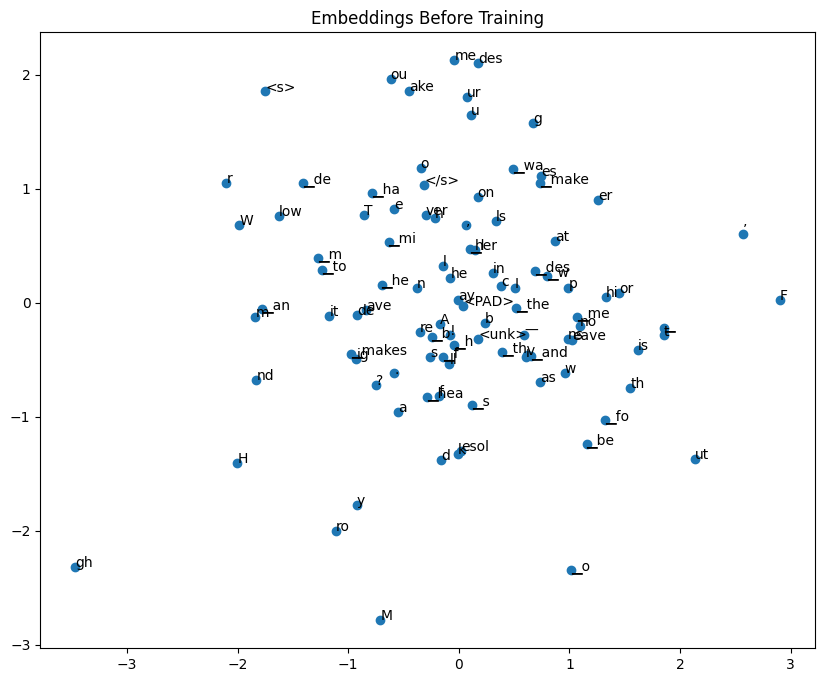

In [19]:
vocab = [sp.id_to_piece(i) for i in range(sp.get_piece_size())]
plot_embeddings(model.word_level_embeddings(), vocab , title="Embeddings Before Training")

In [ ]:
from tqdm import tqdm 

# We will also define an optimizer:
optimizer = torch.optim.SGD(model.parameters(), lr=1e0) # lr is the learning rate - this is our alpha

print("Entering loop")
# And now, this is the training loop:
losses = []
for epoch in tqdm(range(20)):
    optimizer.zero_grad()
    tokens = sp.encode_as_ids(X_train)
    tokens = pad_to_len(tokens, padding_idx, 100)
    tokens = torch.tensor(tokens)
    output = model(tokens)
    output_probs = torch.sigmoid(output)
    loss = torch.mean( (output_probs-y_train)**2 )
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

In [ ]:
plt.figure(figsize=(5,3))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

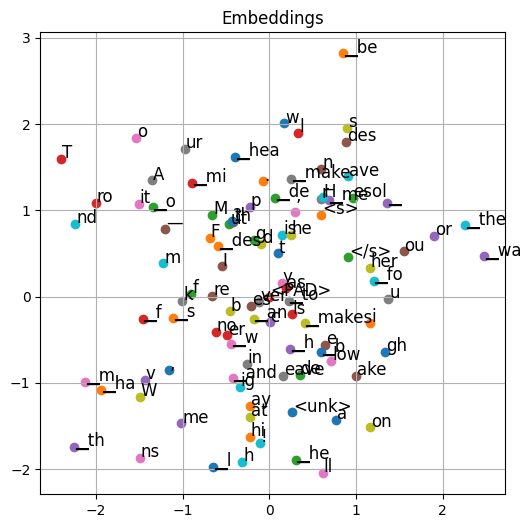

In [25]:
plot_embeddings(model.word_level_embeddings(), id_to_word)

### Evaluating the model

We can convert our 

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Get the predictions for the test set
with torch.no_grad():
    model.eval()
    tokens = sp.encode_as_ids(X_test)
    tokens = pad_to_len(tokens, padding_idx, 25)
    tokens = torch.tensor(tokens)
    output = model(tokens)
    output_probs = torch.sigmoid(output)
    predictions = (output_probs > 0.5).int().numpy()

# Calculate the accuracy and F1 score
accuracy = accuracy_score(
    y_test,
    predictions,
)
f1 = f1_score(
    y_test,
    predictions,
    zero_division=0,
    average='macro',
)
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print(classification_report(
    y_test,
    predictions,
    zero_division=0,
))

Accuracy: 0.42145964233929434
F1 Score: 0.31795435298977587
              precision    recall  f1-score   support

           0       0.42      0.96      0.58       876
           1       0.47      0.03      0.05      1193

    accuracy                           0.42      2069
   macro avg       0.45      0.49      0.32      2069
weighted avg       0.45      0.42      0.28      2069



: 

## Some steps on optimization

You may have noticed that we are using the MSE loss in the code above. This is definitely not optimal, because reductions in MSE+ does not necessarily correspond to increases in accuracy. Instead, we could use the cross-entropy loss.

### Cross-entropy loss

The idea of the cross-entropy loss begins with the negative log likelihood (NLL). Is is usually written as:

$$
\text{NLL} = - \sum_i \log{P(C_i = c_i|X_i)},
$$

where $C_i=c_i$ is the event that the predicted class $C_i$ for the $i$-th input $X_i$ is the correct class $c_i$.

Note that NLL measures the likelihoood that the correct class will be predicted for each item $i$ in the dataset. Therefore, maximizing the negative log likelihood means minimizing the probability that a wrong class will be predicted. Importantly, this is *very* different from minimizing the MSE!

We know that $P(C_i = c_i|X_i)$, in the logistic regressor, is the result of applying the sigmoid (logistic) function to the logits $z_i$. I will call $y_i = P(C_i = c_i|X_i)$ to make reading easier:

$$
y_i = \sigma(z_i) = \frac{1}{1+e^{-z_i}}
$$



We can substitute $y_i$ in the NLL equation to get:

$$
\text{NLL} = - \sum_i \log{y_i} = -\sum_i \log{\frac{1}{1+e^{-z_i}}},
$$

Remember that the log of a division is the subtraction of logs. Hence, we get:

$$
\text{NLL} = -\sum_i \log{1} - \log{1+e^{-z_i}} = -\sum_i 0 - \log{1+e^{-z_i}} = \sum_i \log{(1+e^{-z_i})}.
$$

Also, we are using SGD as the optimizer. The SGD optimizer uses a fixed-step optimization over the parameter space. A more modern approach is the Adam (Adaptive Momentum) optimizer, which adapts the step size so that smoother regions of the parameter space are swept more quickly, and rougher regions automatically lead to smaller steps.

Then, the code becomes this:

In [ ]:
from tqdm import tqdm

# We will also define an optimizer:
optimizer = torch.optim.Adam(
    model.parameters(), lr=1e0)  # lr is the learning rate - this is our alpha

print("Entering loop")
# And now, this is the training loop:
losses = []
model.train()
for epoch in tqdm(range(2)):
    optimizer.zero_grad()
    tokens = sp.encode_as_ids(X_train)
    tokens = pad_to_len(tokens, padding_idx, 100)
    tokens = torch.tensor(tokens)
    output = model(tokens)
    loss = torch.mean(
        torch.binary_cross_entropy_with_logits(
            output.flatten().float(),
            y_train.flatten().float(),
        ), )
    loss.backward()
    optimizer.step()
    losses.append(loss.item())


Entering loop


  4%|▎         | 7/200 [00:07<03:43,  1.16s/it]

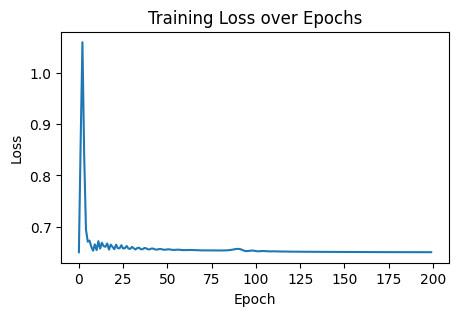

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,3))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Get the predictions for the test set
with torch.no_grad():
    model.eval()
    tokens = sp.encode_as_ids(X_test)
    tokens = pad_to_len(tokens, padding_idx, 25)
    tokens = torch.tensor(tokens)
    output = model(tokens)
    output_probs = torch.sigmoid(output)
    predictions = (output_probs > 0.5).int().numpy()

# Calculate the accuracy and F1 score
accuracy = accuracy_score(
    y_test,
    predictions,
)
f1 = f1_score(
    y_test,
    predictions,
    zero_division=0,
    average='macro',
)
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print(classification_report(
    y_test,
    predictions,
    zero_division=0,
))

Accuracy: 0.5964233929434509
F1 Score: 0.5676211737646739
              precision    recall  f1-score   support

           0       0.52      0.41      0.46       862
           1       0.63      0.73      0.68      1207

    accuracy                           0.60      2069
   macro avg       0.58      0.57      0.57      2069
weighted avg       0.59      0.60      0.59      2069



## Exercises

### 1 - Visualizing embeddings

Change the code for the `SimpleClassifier` class by adding a method that returns the word-level embeddings. Then, calculate the embedding for each word in your vocabulary. Plot the embeddings before training the model, and then after training the model. Do you see a pattern there?

### 2 - Further optimization

Review the whole code for the classifier. Identify all parameters you can change. Identify the possible performance bottlenecks, change the parameters to reduce these bottlenecks, and then run the training process again. Do you see changes?

### 3 - Advanced modelling

Change the `forward` method in `SimpleClassifier` so that the mean only accounts for non-PAD tokens (that is: PAD tokens are ignored). Does that improve performance?